# Attrition Analysis

## BackGround

Talent consistency has long been an important factor plaguing companies, especially in the rapidly evolving Internet era where markets become more volatile with increased uncertainty risks in the macro environment. Attrition rate control and talent retention are always an important part of a company’s development strategy and one of the biggest challenges for the HR department, board of directors and CEO.
Staff turnover can normally be classified in two types, Voluntary and Involuntary (Haggerty). Voluntary means employees voluntarily choose to leave which could be caused by poor work environment, unsatisfied pay, lack of advancement opportunities, long overtime, or even just the employee wanting to make some changes. Involuntary turnover refers to the termination or firing of an employee due to his/her poor performance, behavior issue, etc. 
Questions & Goals
This project will focus on exploring the correlation between turnover and different factors based on the data of IBM, a former dominant player in the information technology and digital industry. Within this analysis, we attempt to address the following questions:-
1. Does over-time work trigger attrition ?
2. How about the salary of IBM employees compared to the market ?
3. How about the effect of position promotion on attrition ?
4. Which model is more appropriate for prediction and how to evaluate?

## Libraries &amp; Version

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pycountry
import matplotlib as mpl
import seaborn as sns
import altair as alt
import scipy
import scipy.stats as stats 
import sklearn
from sklearn import preprocessing

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')


In [2]:
!python --version

print('Pandas version: ', pd.__version__)
print('Numpy version: ', np.__version__)
print('Matplotlib version: ', mpl.__version__)
print('Seaborn version: ', sns.__version__)
print('Altair version: ', alt.__version__)
print('Scipy version: ', scipy.__version__)
print('Sklearn version: ', sklearn.__version__)

Python 3.7.6Pandas version: 
 1.2.3
Numpy version:  1.19.2
Matplotlib version:  3.3.4
Seaborn version:  0.11.1
Altair version:  4.1.0
Scipy version:  1.6.2
Sklearn version:  0.24.1


## Loading data

In [3]:
# Primary dataset
df_ibm = pd.read_csv('assets1/IBM_attrition.csv')
df_ibm.info()  # check the features and whether empty value exists


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
df_ibm.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
# Categorical Features Unique values 
object_list = []
for column in df_ibm.columns:
    if df_ibm[column].dtype == object and len(df_ibm[column].unique()) <= 20:
        object_list.append(column)
        print(f"{column} : {df_ibm[column].unique()}")
        print(df_ibm[column].value_counts())
        print("----------------------------------------------")
object_list

Attrition : ['Yes' 'No']
No     1233
Yes     237
Name: Attrition, dtype: int64
----------------------------------------------
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64
----------------------------------------------
Department : ['Sales' 'Research & Development' 'Human Resources']
Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64
----------------------------------------------
EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64
----------------------------------------------
Gender : ['Female' 'Male']
Male      882
Female    588
Name: Gender, dtype: int64
-

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

## Data Manipulation

The primary dataset has no empty value. So, no null issue should be treated. Our first data treatment is to transform the categorical data before we explore the correlation. There are several features are required to be treated.
- Attrition : {"Yes":1, "No":0}
- OverTime : {"Yes":1, "No":0}
- BusinessTravel : {"Non-Travel":0, "Travel_Rarely":1, "Travel_Frequently":2}

Three columns could be delete directly [Over18, EmployeeCount, StandardHours]
All the other object-type columns will be transformed by get_dummies before machine learning application.


In [6]:
# categorical data transformation.

df_ibm['Attrition'] = df_ibm['Attrition'].map({'Yes':1, 'No':0})
df_ibm['OverTime'] = df_ibm['OverTime'].map({'Yes':1, 'No':0})
df_ibm['BusinessTravel'] = df_ibm['BusinessTravel'].map({"Non-Travel":0, "Travel_Rarely":1, "Travel_Frequently":2})

# delete the column. All the 3 columns are only one constant value. 
df_ibm = df_ibm.drop(['Over18','EmployeeCount', 'StandardHours'], axis=1)

## Data Analysis

In [7]:
# Define functions of visualization


#     fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20)
#     fig.update_layout(width = 800, height=600)
    

def plotlypie2(labels, values, hole, pull, colors, title):
    trace1 = go.Pie(
        labels = labels,
        values = values,
        hole = hole,
        pull=pull,
        marker=dict(colors=colors)
    )
    
    data = [trace1]
    layout = go.Layout(title = title)
    fig = go.Figure(data = data, layout = layout)
    fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20)
    fig.update_layout(width = 800, height=600)
    iplot(fig)

    
def plotlybar(labels1 = None, values1 = None, name1 = None,labels2 = None, values2 = None, name2 =None, markercolor1 = '#9ECAE1', markercolor2 = '#ff99ff', title= None, mode = 'group', orientation = 'v'):
    trace1 = go.Bar(
    x = labels1,
    y = values1,
    orientation = orientation, 
    text = values1,
    name = name1,
    textposition = 'auto',
    marker=dict(
        color=markercolor1#'rgb(58,200,225)',
        )
    )    
    
    if labels2 is not None:
        trace2 = go.Bar(
            x = labels2,
            y = values2,
            name = name2,
            text = values2,
            textposition = 'auto',
            marker=dict(
                color=markercolor2#'rgb(58,200,225)',
            )
        )
        data = [trace1, trace2]
    
    else:
        data = [trace1]
    layout = go.Layout(title = title,xaxis=dict(tickangle=-25), barmode=mode)
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)
    
def snslvplot(x,y,title):
    plt.figure(figsize = (16,8))
    sns.boxenplot(x = x , y = y , palette = "cool" )
    plt.xticks(rotation = 75)
    plt.title(title)
    plt.show()
    
def snsstripplot(x,y,title):
    plt.figure(figsize = (16,8))
    sns.stripplot(x = x , y = y , palette = "cool" )
    plt.xticks(rotation = 75)
    plt.title(title)
    plt.show()
    
def snspointplot(x,y,data, hue, title):
    plt.figure(figsize=(16,8))
    ax = sns.pointplot(x = x, y = y ,data=data,hue=hue,palette="Set2")
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()
    
    
def violin(data, columns):
    fig = go.Figure()
    for ind in list(data[columns].unique()):
        fig.add_trace(go.Violin(x=(data[columns][data[columns] == ind]),
                                y=np.log(data['ConvertedSalary'][data[columns] == ind]),  # only salary is continuous data
                                name=ind,
                                box_visible=True,
                                meanline_visible=True))
    fig.update_layout(width = 1000, height=1000)
    fig.show()

### What's the proportion of the attritions in this dataset ?

In the very beginning of the analysis, I would like to understand whether skewness or imbalance is suffered by our target data. According to [Google Developers](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), the definition of the threshould for imbalanced data can be divided into 3 degrees of imbalance based on the proportion of the minority class, including **Mild** (20-40%), **Moderate** (1-20%), **Extreme** (<1%).

It is an important property that should be considered if we suppose to use the data to train the algothrithm for classification and prediction. To improve the performance of the algorithm, we may need to apply particular **sampling technique**.


In [8]:
# groupby counts
df_attri = df_ibm.groupby('Attrition')['Attrition'].count().reset_index(name='counts')
df_attri['Label'] = ['No', 'Yes']
df_attri['percent'] = df_attri['counts']/ len(df_ibm)

In [9]:
# Pie Chart
def plotlypie(labels, values, hole, pull, colors, title):
    trace1 = go.Pie(
        labels = labels,
        values = values,
        hole = hole,
        pull=pull,
        marker=dict(colors=colors)
    )
    
    data = [trace1]
    layout = go.Layout(title = title)
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)

# plot
colors = ['#9ECAE1', '#E1396C']
plotlypie(df_attri['Label'], df_attri['counts'], 0.6 ,0.05, colors, 'Proportion of Attritions' )

- From the IBM data, we can find the turnover rate is about 16%. Based on the data of [LinkedIn](https://www.linkedin.com/business/talent/blog/talent-strategy/industries-with-the-highest-turnover-rates#:~:text=Tech%20companies%20(software%2C%20not%20hardware,round%20out%20the%20top%20five.)), in 2017, Technology industry suffered the highest turnover rate amongst all the indsutries, achieved 13.2% based on LinkedIn data, while, it is still 3% lower than that of IBM. So, it deserves us to further explore the reasons and try to find the correlations.

- IBM Data distribution about attribution is imbalanced in **Moderate** level. So, we should take care when we design learning algorithm for predictions and select the algorithm evaluation metrics.

### General Correlations with Attrition

Based on the API **Pandas.DataFrame.corr**， we can roughly explore the correlation coefficient of the variables with Attrition. It can be taken as the reference to find the direction for further analysis.

Text(0.5, 1.0, 'Features Correlation with Attrition')

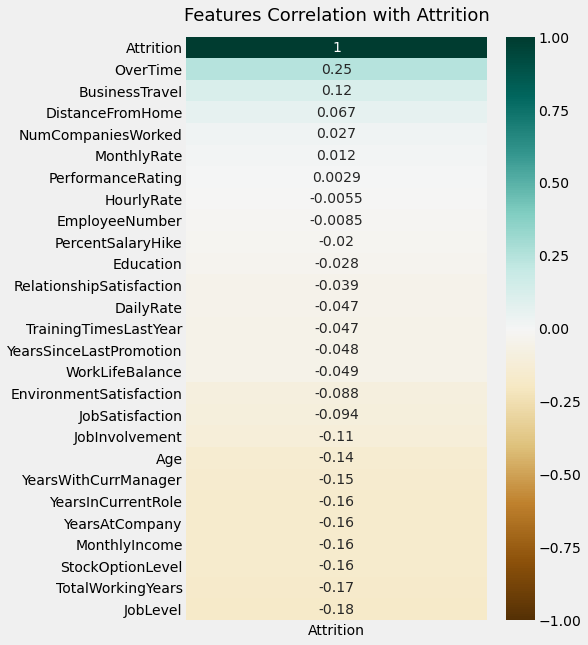

In [10]:
corr_matrix =  df_ibm.corr(method='kendall') # generate the correlation matrix

# visualize the correlation
plt.figure(figsize = (6,10))
corr_heatmap1 = sns.heatmap(corr_matrix[['Attrition']].sort_values(by = 'Attrition', ascending=False), 
                            vmin=-1, vmax=1, annot=True, cmap='BrBG')
corr_heatmap1.set_title('Features Correlation with Attrition', fontdict={'fontsize':18}, pad=16)

### How many people left who suffered overtime ?

In [11]:
# general overtime percentage
ot_rate = len(df_ibm[df_ibm['OverTime']==1])/ len(df_ibm)
print("General OT rate: ", "{:.1%}".format(ot_rate))

# the percentage that OT conditions suffered by people left 
df_left = df_ibm[df_ibm['Attrition']==1]
ot_rate_left = len(df_left[df_left['OverTime']==1])/ len(df_left)
print("OT rate of the Attrition: ", "{:.1%}".format(ot_rate_left))

General OT rate:  28.3%
OT rate of the Attrition:  53.6%


### Department &amp; OverTime &amp; Attrition

In [12]:
df_left['OverTime'].unique()

array([1, 0], dtype=int64)

In [13]:
ot= df_left[df_left['OverTime']==1].groupby('Department')['Department'].count().reset_index(name='OT')
ot

,Department,OT
0,Human Resources,5
1,Research & Development,74
2,Sales,48


In [14]:
# Attrition by Department
df_dept_left = df_left.groupby('Department')['Department'].count().reset_index(name='attrition')

# which department suffered OT in worst ?
df_dept_left['OT'] = df_left[df_left['OverTime']==1].groupby('Department')['Department'].count().values
df_dept_left['attri_ot_pencent'] = df_dept_left['OT'] / df_dept_left['attrition']

# staff numbers by Department 
df_dept_left['counts'] = df_ibm.groupby(['Department'])['Department'].count().values
df_dept_left['general_OT'] = df_ibm[df_ibm['OverTime']==1].groupby(['Department'])['Department'].count().values
df_dept_left['general_ot_pencent'] = df_dept_left['general_OT'] / df_dept_left['counts']
df_dept_left['attri_percent'] = df_dept_left['attrition'] / df_dept_left['counts']
df_dept_left

,Department,attrition,OT,attri_ot_pencent,counts,general_OT,general_ot_pencent,attri_percent
0,Human Resources,12,5,0.416667,63,17,0.269841,0.190476
1,Research & Development,133,74,0.556391,961,271,0.281998,0.138398
2,Sales,92,48,0.521739,446,128,0.286996,0.206278


In [15]:
# Absolute Department Proportion of All Attritions
colors = ['#9ECAE1', '#E1396C']
plotlypie(df_dept_left['Department'] , df_dept_left['attrition'], 0.6 ,0.05, colors, 'Absolute Department Proportion of All Attritions' )

In [16]:
# relative Department proportion of attrition
df_buf = df_ibm.groupby('Department').agg({'JobSatisfaction':'count',}).reset_index()
df_overtime = df_left.groupby('Department').agg({'OverTime':'count',}).reset_index()
df2 = pd.concat([df_overtime, df_buf], axis=1)
df2['attri_percent'] = df2['OverTime'] / df2['JobSatisfaction']

df2.columns = ['0', 'OverTime', 'Department', 'JobSatisfaction',
       'attri_percent']
df2.drop('0', axis=1, inplace=True)
df2['attri_percent_2'] = round(df2['attri_percent'] * 100, 2)
df2['Department'] = ['HR', 'R&D', 'Sales']

df2

,OverTime,Department,JobSatisfaction,attri_percent,attri_percent_2
0,12,HR,63,0.190476,19.05
1,133,R&D,961,0.138398,13.84
2,92,Sales,446,0.206278,20.63


In [17]:
# plot
bars = alt.Chart(df2).mark_bar(color='#9ECAE1').encode(
    x = alt.X('Department:N', axis=alt.Axis(labelAngle=0, titleFontSize=15, labelFontWeight='bold',title=" ")),
    y = alt.Y('attri_percent:Q', axis= None)
).properties(
    width = 400,
    height = 300
).properties(
    title='Turnover rate of each department'
)

text = bars.mark_text(
    dy=-10
).encode(
    text='attri_percent_2:Q'
)

rule = alt.Chart(df2).mark_rule(color='red').encode(
    y='mean(attri_percent):Q'
)

(bars + text + rule).properties(height=900)


alt.LayerChart(...)

In [18]:
df_ot = df_dept_left[['Department', 'attri_ot_pencent', 'general_ot_pencent']]
df_ot = pd.melt(df_ot, id_vars=['Department'], value_vars=['attri_ot_pencent', 'general_ot_pencent'],
                var_name='OT_Condition', value_name='Percentage')
df_ot

,Department,OT_Condition,Percentage
0,Human Resources,attri_ot_pencent,0.416667
1,Research & Development,attri_ot_pencent,0.556391
2,Sales,attri_ot_pencent,0.521739
3,Human Resources,general_ot_pencent,0.269841
4,Research & Development,general_ot_pencent,0.281998
5,Sales,general_ot_pencent,0.286996


In [19]:
# Overtime condition by Department
import altair as alt
df_ot = df_dept_left[['Department', 'attri_ot_pencent', 'general_ot_pencent']]
df_ot.columns=['Department', 'OT rate in Attrition', 'OT rate in general']
df_ot = pd.melt(df_ot, id_vars=['Department'], value_vars=['OT rate in Attrition', 'OT rate in general'],
                var_name='OT_Condition', value_name='Percentage')

# df_ot.columns=['Department', 'OT rate in Attrition', 'OT rate in general']

general_ot = alt.Chart(df_ot).mark_bar(opacity=0.7).encode(
    x = alt.X('Department:N', axis=alt.Axis(labelAngle=0, titleFontSize=15, title=" ")),
    y = alt.Y('Percentage:Q', axis= alt.Axis(title= 'OT Percentage',titleFontSize=15, format='.0%'), stack=None),
    color = alt.Color("OT_Condition:N", 
                        scale = alt.Scale(range=['#9ECAE1', '#5e041f']))
).properties(
    width = 400,
    height = 300
).properties(
    title='OT rate of each department'
)
general_ot

alt.Chart(...)

From the images above, we can have the following findings:
- General OverTime percentage of each depertment is almost the same.
- Among all the attritions, R&D has the highest Overtime percentage, and highest proportion of Attrition.
- Taking the population base into consideration, R&D has the lowest relative attrition rate.

So, we can't conclude that Overtime impacts the decisions of employee to leave or not. Next, we would like to explore other independent variables.

### Job Satisfaction & Attrition

In [20]:
# use groupby to calculate the percentage of each job satisfaction level and merge to make new dataframe
df_satisfy = df_ibm.groupby(['Department','JobSatisfaction'])['JobSatisfaction'].count().reset_index(name='counts')
df_dept = df_ibm.groupby(['Department'])['Department'].count().reset_index(name='counts_dept')
df_satisfy = pd.merge(df_satisfy, df_dept, on='Department', how='outer')
df_satisfy['percent'] = df_satisfy['counts'] / df_satisfy['counts_dept']

df_satisfy

,Department,JobSatisfaction,counts,counts_dept,percent
0,Human Resources,1,11,63,0.174603
1,Human Resources,2,20,63,0.317460
2,Human Resources,3,15,63,0.238095
3,Human Resources,4,17,63,0.269841
4,Research & Development,1,192,961,0.199792
5,Research & Development,2,174,961,0.181061
6,Research & Development,3,300,961,0.312175
7,Research & Development,4,295,961,0.306972
8,Sales,1,86,446,0.192825
9,Sales,2,86,446,0.192825


In [21]:
# Attrition Group : use groupby to calculate the percentage of each job satisfaction level and merge to make new dataframe
df_dept_left = df_left.groupby('Department')['Department'].count().reset_index(name='counts_left_depart')
df_satisfy_left = df_left.groupby(['Department','JobSatisfaction'])['JobSatisfaction'].count().reset_index(name='counts')
df_satisfy_left = pd.merge(df_satisfy_left, df_dept_left, on='Department', how='outer')

df_satisfy_left['percent'] = df_satisfy_left['counts'] / df_satisfy_left['counts_left_depart']
df_satisfy_left

,Department,JobSatisfaction,counts,counts_left_depart,percent
0,Human Resources,1,5,12,0.416667
1,Human Resources,2,2,12,0.166667
2,Human Resources,3,3,12,0.250000
3,Human Resources,4,2,12,0.166667
4,Research & Development,1,38,133,0.285714
5,Research & Development,2,24,133,0.180451
6,Research & Development,3,43,133,0.323308
7,Research & Development,4,28,133,0.210526
8,Sales,1,23,92,0.250000
9,Sales,2,20,92,0.217391


In [22]:
# JobSatisfaction comparison

# general JobSatisfaction mean value by department
satisfy_mean = df_satisfy.groupby('Department').apply(lambda x: sum(x.JobSatisfaction * x.counts)/x.counts.sum())
print("General mean value of Job Satisfaction: \n", satisfy_mean)

# JobSatisfaction mean value of Attritions by department
satisfy_mean_left = df_satisfy_left.groupby('Department').apply(lambda x: sum(x.JobSatisfaction * x.counts)/x.counts.sum())
print("Job Satisfaction mean value of Attritions: \n", satisfy_mean_left)

General mean value of Job Satisfaction: 
 Department
Human Resources           2.603175
Research & Development    2.726327
Sales                     2.751121
dtype: float64
Job Satisfaction mean value of Attritions: 
 Department
Human Resources           2.166667
Research & Development    2.458647
Sales                     2.521739
dtype: float64


In [23]:
# Normalized stacked Bar Chart

# Job satisfaction in general by department
base = alt.Chart(df_satisfy).mark_bar().encode(
    x=alt.X('percent:Q', stack="normalize", axis= None),
    y=alt.Y('Department:N', axis =alt.Axis(labelFontSize=12, title=None)),
    order = alt.Order('JobSatisfaction:O', sort='descending')
)

bars = base.encode(
    detail = 'JobSatisfaction:O',
    color= alt.Color('JobSatisfaction:O', scale = alt.Scale(scheme='redblue')),
)

text = base.mark_text(dx=-15, dy=3, color='black').encode(
    text=alt.Text('percent:Q', format='.1%')
)

depart = alt.layer(bars, text).properties(
    title = 'Job Satisfaction Level Percentage by Department',
    width = 400,
    height = 200
)

# Job satisfaction of attrition by department
base = alt.Chart(df_satisfy_left).mark_bar().encode(
    x=alt.X('percent:Q', stack="normalize", axis= None),
    y=alt.Y('Department:N', axis =alt.Axis(labelFontSize=12, title=None)),
    order = alt.Order('JobSatisfaction:O', sort='descending')
)

bars = base.encode(
    detail = 'JobSatisfaction:O',
    color= alt.Color('JobSatisfaction:O', scale = alt.Scale(scheme='redblue')),
)

text = base.mark_text(dx=-15, dy=3, color='black').encode(
    text=alt.Text('percent:Q', format='.1%')
)

Depart_left = alt.layer(bars, text).properties(
    title = 'Job Satisfaction Level Percentage of Attrition',
    width = 400,
    height = 200
)

Depart_left | depart

alt.HConcatChart(...)

Job Satisfaction are defined into 4 level :-
 - 1 ： Extremely Unsatisfied
 - 2 ： Unsatisfied
 - 3 ： Satisfied
 - 4 ： Extremely Satisfied

Even with high portion of OverTime，over 60% of the employees in both Sales and R&D departments are satisfied with their job. 
From the mean value comparison, even though the mean Job satisfaction of attrition group is lower than the department average, the difference for R&D and Sales are within 0.3. If we compare the proportion of each job satisfaction level, we can find that the unsatisfied proportion has more or less increase compare to general department. So, some of the employees leave probably because they are unsatisfied with them jobs. 

### Monthly Income & Attrition

Text(0, 0.5, 'Monthly Income')

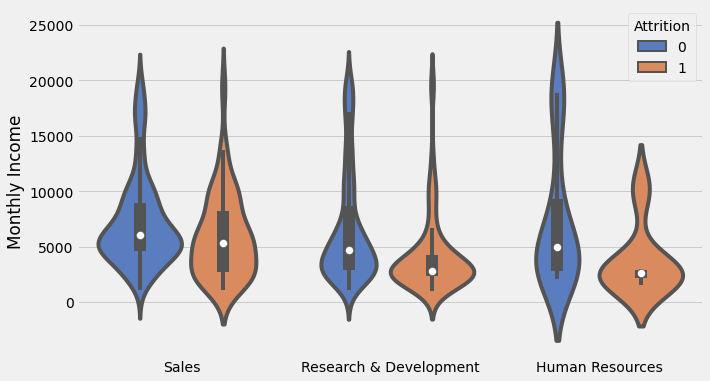

In [24]:
# Monthly income distribution by department
plt.figure(figsize=(10,6))
ax = sns.violinplot(x='Department', y='MonthlyIncome', hue='Attrition', data=df_ibm, palette='muted')
plt.xlabel('')
plt.ylabel( 'Monthly Income')

From the violin plot above, we can find the median values of the salary of all the three departments who stay in the company are higher than those who choose to leave.
To explore the salary condition further, we import the Stack Overfolow survey data and implement cross analysis.

In [25]:
# load data
df_stack = pd.read_csv('assets1/survey_results_public.csv', encoding="cp1252")

# As IBM is US company, we filter the data by country, Employment condition and Company Size.
df_survey = df_stack[(df_stack['Country'] == 'United States') & (df_stack['Employment'] == 'Employed full-time')] 
df2 = df_survey[(df_survey['CompanySize'] == '10,000 or more employees') | (df_survey['CompanySize'] == '5,000 to 9,999 employees')]
df3 = df2[df2['ConvertedSalary'] <= 300000] # outliers filtration

# pick R&D department from IBM dataset
df_ibm_rd = df_ibm[df_ibm['Department'] == 'Research & Development']
df_ibm_rd_att = df_ibm_rd[df_ibm_rd['Attrition'] == 1]


In [26]:
np.random.seed(1)

list_outlier = []
for ind in df2['ConvertedSalary']:
    list_outlier.append(ind / 12)
    
list_wo_outlier = []
for ind in df3['ConvertedSalary']:
    list_wo_outlier.append(ind / 12)

# box plot
y_ibm = list(df_ibm_rd['MonthlyIncome'])
y_sfo_outlier = list_outlier
y_sfo_wo_outlier = list_wo_outlier
y_ibm_att = list(df_ibm_rd_att['MonthlyIncome'])

fig = go.Figure()
fig.add_trace(go.Box(y=y_ibm_att, name="IBM R&D Attrition", line=dict(color='#1e99d9')))
fig.add_trace(go.Box(y=y_ibm, name="IBM R&D in general", line=dict(color='#243138')))
# fig.add_trace(go.Box(y=y_sfo_outlier))
fig.add_trace(go.Box(y=y_sfo_wo_outlier, name="Stack Overflow Survey ", line=dict(color='#733e10')))

fig.update_layout(width = 800, height=600, 
                showlegend=False, 
                title_text = 'Monthly Income Distribution')
              
fig.show()

Within IBM R&D Department, the monthly income of the attrition groups are lower than the department average. The brown box is generated by the survey data from Stack Overflow, filtered the country as the US and company size with over 5000 employees, to make apple-to-apple comparison. The gap between IBM attrition group from R&D department to the market condition is larger!

The exploration of salary can reasonably support our inference that people tend to leave and choose a job with better income packages. 


### Exploration of TotolWorkingYears, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion,Age - Parato Chart

In [27]:
# total working years
df_totalworkyear= df_left.groupby('TotalWorkingYears')['TotalWorkingYears'].count().reset_index(name='counts')
df_totalworkyear.columns = ['year', 'counts']
df_totalworkyear['cumpercent'] = df_totalworkyear['counts'].cumsum()/df_totalworkyear['counts'].sum()


In [28]:
def years_pareto(df):
    """
    This is the basic demonstration of the approach. The basic pareto chart is composed of two parts. 
        - Bar : Distribution of the transaction amount with each countries, sorted in descending order.
        - Line : Cumulative percentage line 

    In this special cases, I won't sort the counts, because the sequence of years is better for me to 
    analyze the attrition condition by year interval if needed.
    """
    #sort_order = df['year'].tolist() # sort order

    # define the base of the chart, x axis is shared.
    base = alt.Chart(df).encode(
        x = alt.X('year:O', axis = alt.Axis(title = 'Years-Since-Last-Promotion', titleFontSize=14, labelAngle=0))
    ).properties(
        width = 800,
        height = 300
    )

    # plot the bars, defining bar size and opacity.
    bars = base.mark_bar(size=15, opacity=0.5).encode(
        y = alt.Y('counts:Q', axis = alt.Axis(title='Number of Attritions', titlePadding=10, titleFontSize=14))
    )

    # plot the line
    line = base.mark_line(
        strokeWidth= 1.5,
        color = '#cb4154',
    ).encode(
        y = alt.Y('cumpercent:Q',
            axis = alt.Axis(title = 'Cumulative percentage', titlePadding=10, titleFontSize=14,format='.0%')),
        text = alt.Text('cumpercent:Q')
    )

    # plot the points
    points = base.mark_circle(
        strokeWidth = 3,
        color = '#cb4154',
    ).encode(
        y = alt.Y('cumpercent:Q', axis = None),
        text = alt.Text('cumpercent:Q')
    )

    # mark text for each point.
    points_text = points.mark_text(
        align = 'left',
        baseline = 'middle',
        dx = -10, # Nudges text to right so it doesn't appear on top of the bar
        dy = -10
    ).encode(
        y = alt.Y('cumpercent:Q', axis=None),
        text = alt.Text('cumpercent:Q', format='.0%'),
        color = alt.value('#cb4154')
    )


    Figure = (bars + line + points + points_text).resolve_scale(
        y = 'independent'
    ).configure_mark().configure_view(
        strokeWidth = 0
    )

    return Figure


In [29]:
years_pareto(df_totalworkyear).properties(
        title = {
            'text': 'Attrition Distrition along the Total Working Years',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

In [30]:
# Years At Company 

df_yearatcompany= df_left.groupby('YearsAtCompany')['YearsAtCompany'].count().reset_index(name='counts')
df_yearatcompany.columns = ['year', 'counts']
df_yearatcompany['cumpercent'] = df_yearatcompany['counts'].cumsum()/df_yearatcompany['counts'].sum()

In [31]:
years_pareto(df_yearatcompany).properties(
        title = {
            'text': 'Attrition Distrition by Years at Company',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

In [32]:
# YearsInCurrentRole

df_yearcurrentrole= df_left.groupby('YearsInCurrentRole')['YearsInCurrentRole'].count().reset_index(name='counts')
df_yearcurrentrole.columns = ['year', 'counts']
df_yearcurrentrole['cumpercent'] = df_yearcurrentrole['counts'].cumsum()/df_yearcurrentrole['counts'].sum()

years_pareto(df_yearcurrentrole).properties(
        title = {
            'text': 'Attrition Distrition by Years in Current Roles',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

In [33]:
# YearsSinceLastPromotion
df_promot= df_left.groupby('YearsSinceLastPromotion')['YearsSinceLastPromotion'].count().reset_index(name='counts')
df_promot.columns = ['year', 'counts']
df_promot['cumpercent'] = df_promot['counts'].cumsum()/df_promot['counts'].sum()

years_pareto(df_promot).properties(
        title = {
            'text': 'Attrition Distrition by Years-Since-Last-Promotion',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

In [34]:
# Age
df_age= df_left.groupby('Age')['Age'].count().reset_index(name='counts')
df_age.columns = ['year', 'counts']
df_age['cumpercent'] = df_age['counts'].cumsum()/df_age['counts'].sum()

years_pareto(df_age).properties(
        title = {
            'text': 'Attrition Distrition by Age',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

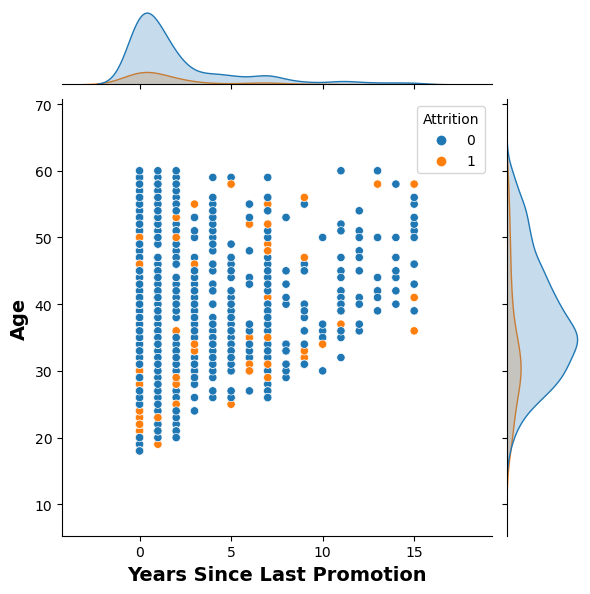

In [35]:
# Age & Years-since-last-promotion & Attrition
plt.style.use('default')
jplot = sns.jointplot(data=df_ibm, x="YearsSinceLastPromotion", y="Age", hue="Attrition", height=6)
jplot.set_axis_labels(xlabel='Years Since Last Promotion', ylabel= 'Age', fontsize=14, fontweight='bold')


“Employees want to feel recognized, valued and engaged”, [Joel Garfinkle](https://garfinkleexecutivecoaching.com/articles/how-to-retain-employees/employee-retention-promotion
) believes that one way to insure you keep valuable employees is to promote them. However, the IBM data tells us another story. The revised Pareto Chart illustrates that 82% of the attritions achieved promotion within the past 3 years.

The joint plot between Age and Years-Since-Last-Promotion demonstrates that IBM has healthy age composition with a significant portion of youngsters, most of which has been promoted within the past 3 years. Even though being promoted, some of the employees may still choose to leave because of other factors or more desired career or academic opportunities outside.

### Prediction

In [36]:
# model and metrics import
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

In [37]:
# dummy transformation
df_ibm = pd.get_dummies(df_ibm, columns=['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus'])

In [38]:
#df_ibm.head()
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   Attrition                          1470 non-null   int64
 2   BusinessTravel                     1470 non-null   int64
 3   DailyRate                          1470 non-null   int64
 4   DistanceFromHome                   1470 non-null   int64
 5   Education                          1470 non-null   int64
 6   EmployeeNumber                     1470 non-null   int64
 7   EnvironmentSatisfaction            1470 non-null   int64
 8   HourlyRate                         1470 non-null   int64
 9   JobInvolvement                     1470 non-null   int64
 10  JobLevel                           1470 non-null   int64
 11  JobSatisfaction                    1470 non-null   int64
 12  MonthlyIncome       

In [39]:
# Compare the Logistic Regression Model V.S. Decision Tree Model V.S. Random Forest Model

# Create train and test splits
X = df_ibm.drop('Attrition', axis=1)
y=df_ibm['Attrition']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15, random_state=123, stratify=y)

#Logistic Regression Model
model1 = LogisticRegression(class_weight="balanced",)
model1.fit(X_train,y_train)
print ("\n\n ---Logistic Model---")
print("Accuracy score: {}".format(accuracy_score(y_test, model1.predict(X_test))))
logit_roc_auc = roc_auc_score(y_test, model1.predict(X_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, model1.predict(X_test)))


#Decision Tree Model
model2=DecisionTreeClassifier(min_weight_fraction_leaf=0.01,class_weight="balanced",)
model2.fit(X_train,y_train)
print("\n\n ---Decision Tree Model ---")
print("Accuracy score: {}".format(accuracy_score(y_test, model2.predict(X_test))))
dtree_roc_auc=roc_auc_score(y_test,model2.predict(X_test))
print("Decision Tree AUC = %2.2f" % dtree_roc_auc)
print(classification_report(y_test,model2.predict(X_test)))

#Random Forest Model
model3=RandomForestClassifier( n_estimators=1000,max_depth=None,min_samples_split=10,class_weight="balanced")
model3.fit(X_train,y_train)
print("\n\n --- Random Forest Model ----")
print("Accuracy score: {}".format(accuracy_score(y_test, model3.predict(X_test))))
rforest_roc_auc=roc_auc_score(y_test,model3.predict(X_test))
print("Random forest AUC = %2.2f" % rforest_roc_auc)
print(classification_report(y_test,model3.predict(X_test)))




 ---Logistic Model---
Accuracy score: 0.6289592760180995
Logistic AUC = 0.63
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       185
           1       0.25      0.64      0.36        36

    accuracy                           0.63       221
   macro avg       0.57      0.63      0.55       221
weighted avg       0.79      0.63      0.68       221



 ---Decision Tree Model ---
Accuracy score: 0.7873303167420814
Decision Tree AUC = 0.71
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       185
           1       0.40      0.58      0.47        36

    accuracy                           0.79       221
   macro avg       0.65      0.71      0.67       221
weighted avg       0.83      0.79      0.80       221



 --- Random Forest Model ----
Accuracy score: 0.8416289592760181
Random forest AUC = 0.57
              precision    recall  f1-score   support

           0       0.86      0

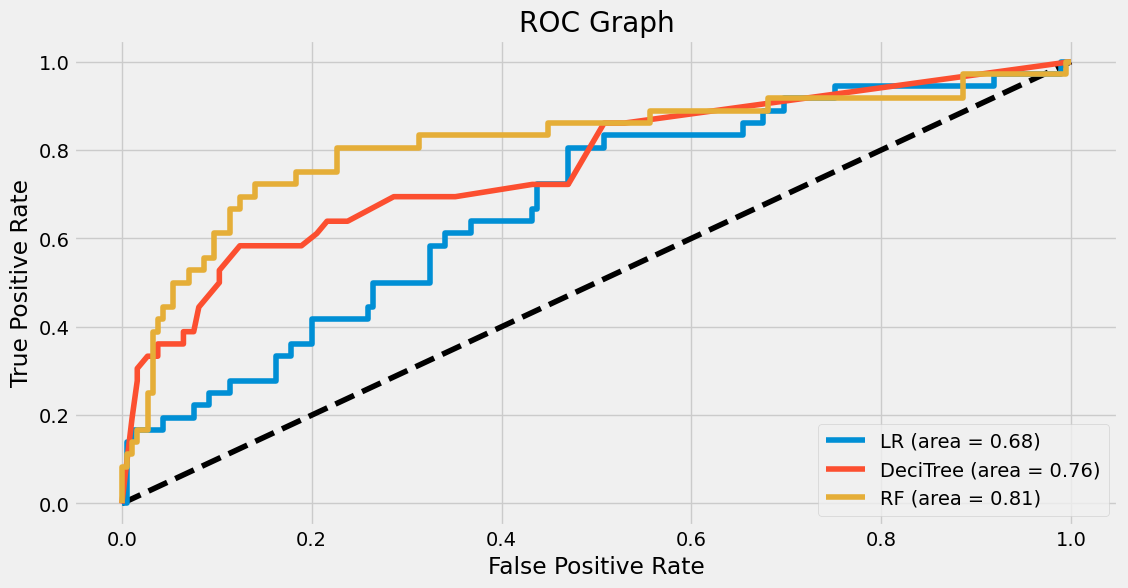

In [40]:
# ROC Graph 
from sklearn.metrics import roc_curve, auc

y_pred_prob1 = model1.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)
auc_1 = auc(fpr1, tpr1)
y_pred_prob2 = model2.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
auc_2 = auc(fpr2, tpr2)
y_pred_prob3 = model3.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)
auc_3 = auc(fpr3, tpr3)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "LR (area = %0.2f)" % auc_1)
plt.plot(fpr2, tpr2, label= "DeciTree (area = %0.2f)" % auc_2)
plt.plot(fpr3, tpr3, label= "RF (area = %0.2f)" % auc_3)
# plt.plot(fpr4, tpr4, label= "Sigmoid")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d18beb40-c7f5-4252-8f44-871d7ae07af1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

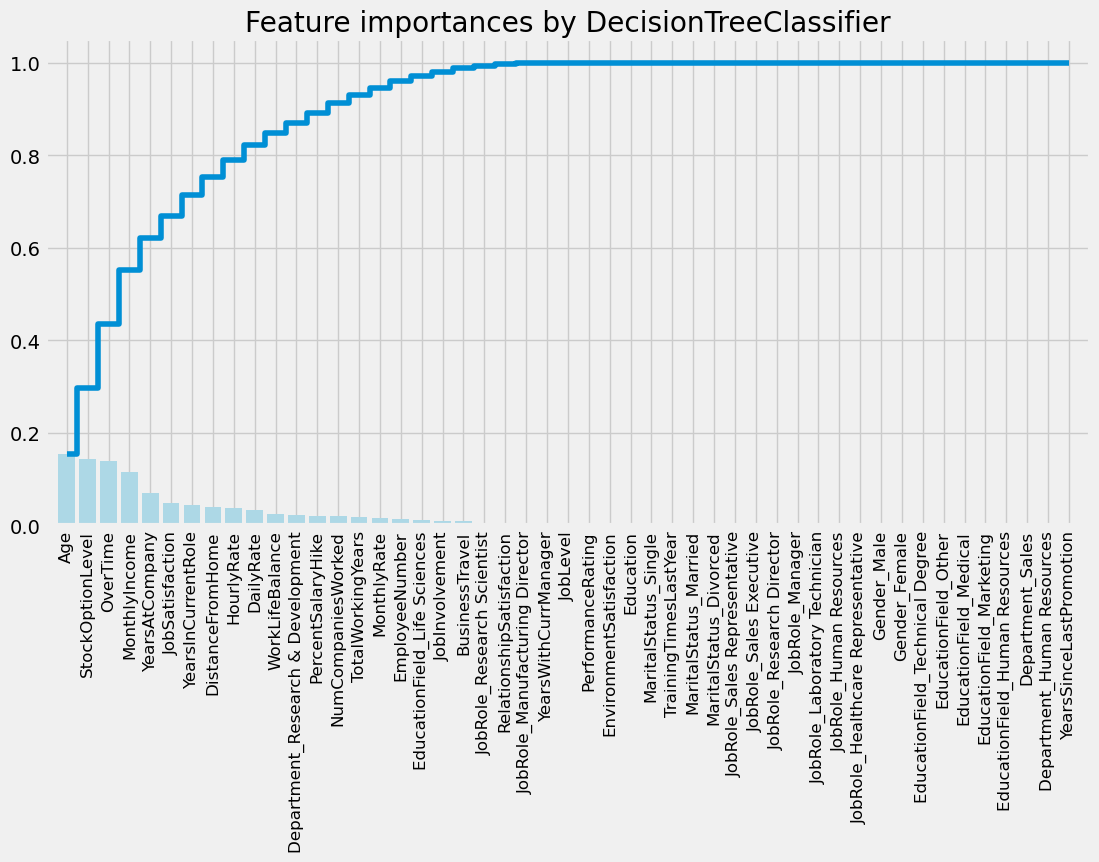

In [41]:
# plot feature importantce of decision tree

importances = model2.feature_importances_
feat_names = df_ibm.drop(['Attrition'],axis=1).columns

indices = np.argsort(importances)[::-1]
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation=90,fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()

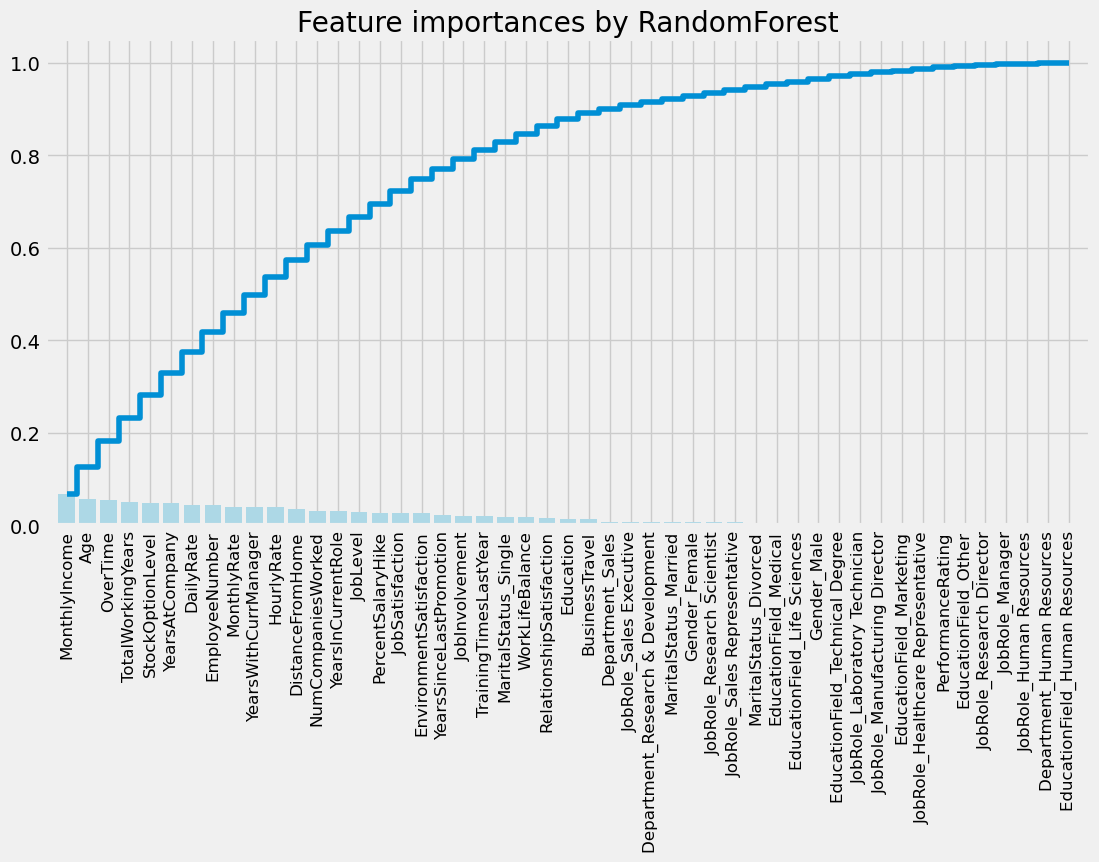

In [42]:
# plot feature importance of Random Forest
importances = model3.feature_importances_
feat_names = df_ibm.drop(['Attrition'],axis=1).columns

indices = np.argsort(importances)[::-1]
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation=90,fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()

In [43]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

# Scatter plot 
trace = go.Scatter(
    y = model3.feature_importances_,
    x = X.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = model3.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = X.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Random Forest performs the best with 82% probability to make right prediction. By plotting bar chart of feature importance with the cumulative line, the most important features can be revealed which supports the highest weight for the model to make classification, including Monthly Income, Age, Over Time, Total Working Years, etc.  Comparing to the prediction accuracy from [Dr. Hamza Bendemra](https://towardsdatascience.com/building-an-employee-churn-model-in-python-to-develop-a-strategic-retention-plan-57d5bd882c2d
), the performance of Random Forest and Logistic Regression can be further improved after fine tuning of hyper-parameters, especially the latter one achieving 86%. 

In the future, we can explore further about the Stack Overflow survey data and try to find some other data for this topic. In addition, model optimization, hyper-parameters fine-tuning, evaluation of other models, such as XGboost or even Neural Networks, can be explored.